# Bond Future Intraday Price Movement Prediction

Roger Wang : hanyi.wang@wustl.edu

In [1]:
import os
from __future__ import print_function, absolute_import
from gm.api import *
import numpy as np
import pandas as pd
import pickle as pkl
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
# 数据来源： 掘金量化SDK （https://www.myquant.cn/docs/guide/35#a0e2f0be08fe7317）
# 可以直接提取数据，掘金终端需要打开，接口取数是通过网络请求的方式，效率一般，行情数据可通过subscribe订阅方式
# 设置token， 查看已有token ID,在用户-秘钥管理里获取
set_token('e225ffbe4f9b494a07932dc13aa9a161c78f3077')
os.chdir("D:\Guotai")


## Data

In [2]:
start_time = '2020-02-23 09:30:00'
end_time = '2021-05-21 15:15:00'
df_T = history(symbol='CFFEX.T', frequency='60s', start_time=start_time, end_time=end_time,
                fields='symbol,frequency,open,close,high,low,amount,volume,position,bob,eob', adjust=ADJUST_PREV, adjust_end_time='2021-06-01', df=True)

data = df_T


### Out of Sample Data

In [3]:
# start_time_out = '2021-06-01 09:30:00'
# end_time_out = '2021-06-03 15:15:00'
# df_o = history(symbol='CFFEX.T', frequency='60s', start_time=start_time_out, end_time=end_time_out,
#                 fields='symbol,frequency,open,close,high,low,amount,volume,position,bob,eob', adjust=ADJUST_PREV, adjust_end_time='2021-06-01', df=True)


## Preprocessing

In [4]:
# nulls = data.isnull().sum() / data.shape[0]
# for i in range(0, 10):
#     print(
#             f'{len(nulls[nulls.values <= (i / 100)]) * 100 / len(nulls)}% columns have null values less than {i * 1}% rows')

## Feature Construction

#### Delta

In [5]:
# Create Delta Variable

df_temp = data

delta = np.zeros(len(df_temp['close']))
for i in range(1,len(df_temp['close'])):
    
    lastItem = df_temp['close'][i-1]
    diff = df_temp['close'][i] - lastItem
    delta[i] = diff
delta = pd.DataFrame(delta)
df_temp['delta'] = delta

df_T = df_temp

In [6]:
# print(df_T.head())

### RSI

In [7]:
dUp,dDown = delta.copy(),delta.copy()
dUp[dUp < 0] = 0
dDown[dDown > 0] = 0
window = 15 # RSI window length

# Simple moving average
rollUp_s = dUp.rolling(window).mean()
rollDown_s = dDown.rolling(window).mean().abs()

# Exponential moving average
rollUp_e = dUp.ewm(span = window).mean()
rollDown_e = dDown.abs().ewm(span = window).mean()


In [8]:
RSI_EMA = rollUp_e / (rollUp_e + rollDown_e) * 100 # RSI for exponential moving average
RSI_EMA = pd.DataFrame(RSI_EMA) 
RSI_SMA = rollUp_s / (rollUp_s + rollDown_s) * 100
RSI_SMA = pd.DataFrame(RSI_SMA)
# print("Exponential Moving average RSI (More Sensitive):")
# print(RSI_EMA.head(window))
# print("Simple Moving average RSI:")
# print(RSI_SMA.head(window))

#================= RSI feature Constructed =================
data['RSI_E'] = RSI_EMA
data['RSI_S'] = RSI_SMA
# 这里之后可以换成一个feature不用两个RSI都用， but也没太大所谓反正电费不要钱

#### RSI Indicator

In [9]:
upBar = 80
lowBar = 20
alarm_RSIe,alarm_RSIs = np.zeros(len(RSI_EMA)),np.zeros(len(RSI_SMA))
alarm_RSIe,alarm_RSIs = pd.DataFrame(alarm_RSIe),pd.DataFrame(alarm_RSIs)

# 之后可以再加入多个层级的分几层支撑

alarm_RSIe[RSI_EMA >= 80] = -2
# alarm_RSIe[RSI_EMA >= 70] = -1
# alarm_RSIe[RSI_EMA <= 30] = 1
alarm_RSIe[RSI_EMA <= 20] = 2

alarm_RSIs[RSI_SMA >= 80] = -2
# alarm_RSIs[RSI_SMA >= 70] = -1
# alarm_RSIs[RSI_SMA <= 30] = 1
alarm_RSIs[RSI_SMA <= 20] = 2


# np.count_nonzero(alarm_RSIe)
# np.count_nonzero(alarm_RSIs)
alarm_RSIe.count()

#================= RSI Alarm feature Constructed =================
data['alarm_RSIs'] = alarm_RSIs
data['alarm_RSIe'] = alarm_RSIe
# 这里之后可以换成一个feature不用两个RSI都用， but也没太大所谓反正电费不要钱

上面这个暂时有点问题，需要加一个visualization来看一下，不要RSI再震荡或者徘徊的时候也发出乱七八糟的信号，

其实这个地方的分类有些类似于康总说的分行情情况选取策略，

### OHLC_avg

In [10]:
# OHCL Open-High-CLose-Low Avg Feature construction

#np.random.seed(10)
OHLC_avg = data[['open', 'close', 'high', 'low']].mean(axis=1)
HLC_avg = data[['high', 'low', 'close']].mean(axis=1)
close_val = data[['close']]

#================= OHLC_avg feature Constructed =================
data['OHLC_avg'] = OHLC_avg 

#### Visualize OHLC

In [11]:
# # plotting data and compare
# obs = np.arange(1,len(df_T)+1,1)
# #====================================================
# plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
# #plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
# plt.plot(obs, close_val, 'g', label = 'Closing price')
# plt.legend(loc = 'upper right')
# plt.show()

In [12]:

# scaler = MinMaxScaler()
# OHLC_scaled = np.reshape(OHLC_avg.values,(len(OHLC_avg),1))
# OHLC_scaled = scaler.fit_transform(np.array(OHLC_avg).reshape(-1, 1))
# #OHLC_scaled = pd.DataFrame(OHLC_scaled)



### TS / TF

以跨品种国债期货合约走势为因子进行判断

In [13]:
# # 两年期国债期货
# df_TS = history(symbol='CFFEX.TS', frequency='60s', start_time=start_time, end_time=end_time,
#                 fields='symbol,frequency,open,close,high,low,amount,volume,position,bob,eob', adjust=ADJUST_PREV, adjust_end_time='2021-06-01', df=True)
# # 五年期国债期货
# df_TF  = history(symbol='CFFEX.TF', frequency='60s', start_time=start_time, end_time=end_time,
#                 fields='symbol,frequency,open,close,high,low,amount,volume,position,bob,eob', adjust=ADJUST_PREV, adjust_end_time='2021-06-01', df=True)


### BBIBOLL

### Standard Deviation

#### 涨跌幅 Std

In [14]:
interval = window # Subject to change

In [15]:
var_delta = pd.DataFrame(delta.rolling(interval).std())
data['var_delta'] = var_delta

#### OHLC Std

In [16]:
var_OHLCavg = OHLC_avg.rolling(interval).std()
data['std_OHLCavg'] = var_OHLCavg 

### World Quant Alphas

reference : World Quant Alpha 101 (https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf)

#### Helper Function

In [17]:
#
def a_ret(open,close):
    haha = np.log(open) - np.log(close)**2
    return haha

In [18]:
def a_sum(target,days):
    res = [0]* len(target)
    for i in range(days-1,len(target)):
        res[i] = target.rolling(days).sum()
    return res
       

In [19]:
# rank(x) = cross-sectional rank 
def a_rank(x):
    res = np.array(pd.DataFrame(x).rank(pct=True)).squeeze().tolist()
    return res

In [20]:
# correlation(x, y, d) = time-serial correlation of x and y for the past d days
def a_cor(x,y,d):
    res = [0] * len(x)
    for i in range(d-1,len(x)):
        res[i] = np.correlate(x[i-d+1:i],y[i-d+1:i])

    return res
    

In [21]:
# adv(d) = average daily dollar volume for the past d days
def a_adv(vol,d):
    res = [0]* len(vol)
    res = vol.rolling(d).mean()
    return res
    
  

In [22]:
# delta(x, d) = today’s value of x minus the value of x d days ago 
def a_delta(x,d):
    res = [0]* len(x)
    for i in range(0,len(x)-d-1):
        res[i+d] = x[i+d] - x[i]
    return res

#### Alpha #101

 ((close - open) / ((high - low) + .001)) 你最简单

In [23]:
a_101 = (data['close'] - data['open'])/((data['high'] - data['low']) + 0.001)
data['a_101'] = pd.DataFrame(a_101)

#### Alpha #028 

 scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close)) 影线

In [24]:
adv = a_adv(data['amount'],10)
a_028 = np.array(a_cor(adv[0:],data['low'][0:],5),dtype = np.float)
data['a_028'] = a_028
# data['a_028'].head(window)

#### Alpha #006

 (-1 * correlation(open, volume, 10))  price-volume relationship 价量关系

In [25]:
a_006 = a_cor(data['open'],data['amount'],10)
data['a_006'] = np.array(a_006,dtype = np.float)
#data['a_006'].head(window)

#### Alpha #

## Data Preparation

#### Prepare X

In [26]:
data_x = data.drop(['symbol','frequency','bob','eob'],axis = 1)
data_x = data_x[window:] # drop null for variance and RSI


data_x.reset_index(drop = True,inplace = True)
print(data_x.head())

      open    close     high      low      amount  volume  position  delta  \
0  100.415  100.420  100.430  100.415  1.5063e+08     150     56105  0.000   
1  100.420  100.395  100.420  100.385  5.4617e+08     544     55997 -0.025   
2  100.395  100.380  100.405  100.380  3.5038e+08     349     55908 -0.015   
3  100.380  100.400  100.405  100.380  1.9979e+08     199     55935  0.020   
4  100.395  100.410  100.415  100.395  1.8274e+08     182     55946  0.010   

     RSI_E    RSI_S  alarm_RSIs  alarm_RSIe  OHLC_avg  var_delta  std_OHLCavg  \
0  37.8460  43.5893         0.0         0.0  100.4200     0.0202       0.0117   
1  26.1027  27.0249         0.0         0.0  100.4050     0.0183       0.0126   
2  21.5236  34.4804         0.0         0.0  100.3900     0.0126       0.0161   
3  38.0801  38.7114         0.0         0.0  100.3912     0.0136       0.0187   
4  44.7419  43.7515         0.0         0.0  100.4037     0.0139       0.0195   

    a_101       a_028       a_006  
0  0.312

#### Prepare Y

注意在构建Y4的时候我们对于下跌预测有倾向性，如果同时满足在下一分钟上涨两个tick或者下跌两个tick优先选择预测下跌两个tick

In [27]:
data_temp = data_x

y1 = [0] * len(data_temp)
y2 = [0] * len(data_temp)
y3 = [0] * len(data_temp)
y4 = [0] * len(data_temp)
for i in range(0,len(data_temp)-1):
    y1[i] = data_temp['high'][i+1] - data_temp['close'][i]
    y2[i] = data_temp['low'][i+1] - data_temp['close'][i]
    y3[i] = (data_temp['open'][i+1]+data_temp['close'][i+1]+data_temp['low'][i+1]+data_temp['high'][i+1])/4 - (data_temp['open'][i]+data_temp['close'][i]+data_temp['low'][i]+data_temp['high'][i])/4
    if  y2[i] <= -0.01:
        y4[i] = -1
    elif y1[i] >= 0.01:
        y4[i] = 1
    
    else:
        y4[i] = 0
    
print("haha")
y1,y2,y3,y4 = pd.DataFrame(y1),pd.DataFrame(y2),pd.DataFrame(y3),pd.DataFrame(y4)
data_y = pd.concat([y1,y2,y3,y4],axis = 1)
data_y.columns = ['y1','y2','y3','y4']

output_count = data_y.shape[1]  # number of outputs

data_y.head()

haha


,y1,y2,y3,y4
0,0.000,-0.035,-1.5001e-02,-1
1,0.010,-0.015,-1.5001e-02,-1
2,0.025,0.000,1.2512e-03,1
3,0.015,-0.005,1.2501e-02,1
4,0.005,-0.020,1.9073e-06,-1


In [28]:
# One hot encoding
pd.get_dummies(data_y['y4'],prefix =['movement'])
data_y_mov = pd.get_dummies(data_y['y4'],prefix =['movement'])
data_y_mov = data_y_mov[:-1]
data_y_mov.head

<bound method NDFrame.head of        ['movement']_-1  ['movement']_0  ['movement']_1
0                    1               0               0
1                    1               0               0
2                    0               0               1
3                    0               0               1
4                    1               0               0
...                ...             ...             ...
78720                0               1               0
78721                0               0               1
78722                0               1               0
78723                0               1               0
78724                1               0               0

[78725 rows x 3 columns]>

#### Check balance

In [29]:
data_y['y4'].value_counts()

-1    28567
 1    25611
 0    24548
Name: y4, dtype: int64

#### Scaling

In [30]:
scaler1 = MinMaxScaler(feature_range = (-1,1))
scaler2 = MinMaxScaler(feature_range = (0,1))

#s1_col = ['delta','alarm_RSIs','alarm_RSIe']

x_neg = data_x[['delta','alarm_RSIs','alarm_RSIe']]
x_pos = data_x.drop('delta',axis = 1).drop('alarm_RSIs',axis = 1).drop('alarm_RSIe',axis = 1)

scaler1 = scaler1.fit(x_neg)
scaler2 = scaler2.fit(x_pos)

x_neg = np.reshape(x_neg.values,(x_neg.shape[0],x_neg.shape[1]))
x_neg_scaled = scaler1.transform(x_neg)


In [31]:
x_pos = np.reshape(x_pos.values,(x_pos.shape[0],x_pos.shape[1]))
x_pos_scaled = scaler2.transform(x_pos)



In [32]:
print(x_neg_scaled.shape)
print(x_pos_scaled.shape)

(78726, 3)
(78726, 15)


In [33]:
data_x_scaled = np.concatenate((x_pos_scaled,x_neg_scaled),axis = 1)

In [34]:
scaler3 = MinMaxScaler(feature_range = (0,1)) # 因为这个价格大部分情况是单边的所以应该是01范围的区间
scaler3 = scaler3.fit(data_y)
data_y_scaled = scaler3.transform(data_y)

In [35]:
print(data_y_scaled.shape)

(78726, 4)


#### Test/Train Split

In [36]:
#data_scaled = np.concatenate((data_x_scaled,data_y_scaled),axis = 1)
index = int(len(data_x_scaled) * 0.75)
x_train = data_x_scaled[0:index]
x_test = data_x_scaled[index:-1] #last one no target
y_train = data_y_scaled[0:index]
y_test = data_y_scaled[index:-1] 
y_train_mov = np.array(data_y_mov[0:index])
y_test_mov = np.array(data_y_mov[index:])

In [37]:
len(y_test_mov)

19681

#### Check Training Set Balance

In [38]:
# y_test_mov.describe()

In [39]:
# Reshape Data
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

 ### Examine Data Before Train

## Model Construction

### LSTM

In [48]:
step_size = 1
model = Sequential()
model.add(LSTM(32,return_sequences = True,activation = 'tanh'))
model.add(LSTM(16))
#model.add(Dropout(0.2))
model.add(Dense(3,kernel_initializer = 'normal')) # output 4 target variables

#### Training

In [49]:
model.compile(loss = 'mean_squared_error',optimizer = 'adagrad')
model.fit(x_train,y_train_mov, epochs = 100, batch_size = 16,verbose = 2)

Epoch 1/100
3691/3691 - 12s - loss: 0.2892
Epoch 2/100
3691/3691 - 6s - loss: 0.2568
Epoch 3/100
3691/3691 - 6s - loss: 0.2383
Epoch 4/100
3691/3691 - 6s - loss: 0.2272
Epoch 5/100
3691/3691 - 6s - loss: 0.2218
Epoch 6/100
3691/3691 - 6s - loss: 0.2196
Epoch 7/100
3691/3691 - 6s - loss: 0.2187
Epoch 8/100
3691/3691 - 6s - loss: 0.2184
Epoch 9/100
3691/3691 - 7s - loss: 0.2183
Epoch 10/100
3691/3691 - 6s - loss: 0.2183
Epoch 11/100
3691/3691 - 6s - loss: 0.2183
Epoch 12/100
3691/3691 - 7s - loss: 0.2182
Epoch 13/100
3691/3691 - 6s - loss: 0.2182
Epoch 14/100
3691/3691 - 6s - loss: 0.2182
Epoch 15/100
3691/3691 - 6s - loss: 0.2182
Epoch 16/100
3691/3691 - 6s - loss: 0.2182
Epoch 17/100
3691/3691 - 6s - loss: 0.2182
Epoch 18/100
3691/3691 - 6s - loss: 0.2182
Epoch 19/100
3691/3691 - 7s - loss: 0.2182
Epoch 20/100
3691/3691 - 6s - loss: 0.2182
Epoch 21/100
3691/3691 - 6s - loss: 0.2181
Epoch 22/100
3691/3691 - 7s - loss: 0.2181
Epoch 23/100
3691/3691 - 6s - loss: 0.2181
Epoch 24/100
3691/3

#### Prediction

In [50]:
# prediction
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

#### Inverse Tranformation

In [43]:
train_pred_af = scaler3.inverse_transform(train_pred)
y_train_af = scaler3.inverse_transform(y_train)
test_pred_af = scaler3.inverse_transform(test_pred)
y_test_af = scaler3.inverse_transform(y_test)

ValueError: operands could not be broadcast together with shapes (59044,3) (4,) (59044,3) 

#### RMSE

In [45]:
# y1 train
train_Score = math.sqrt(mean_squared_error(y_train_af[:,0],train_pred_af[:,0]))
print('Train RMSE y1 :' , (train_Score))
# y2
train_Score = math.sqrt(mean_squared_error(y_train_af[:,1],train_pred_af[:,1]))
print('Train RMSE y2 :' , (train_Score))
# y3
train_Score = math.sqrt(mean_squared_error(y_train_af[:,2],train_pred_af[:,2]))
print('Train RMSE y3 :' , (train_Score))
# # y4
# train_Score = math.sqrt(mean_squared_error(y_train_af[:,3],train_pred_af[:,3]))
# print('Train RMSE y4 :' , (train_Score))

NameError: name 'y_train_af' is not defined

In [ ]:
# y1 test
test_Score = math.sqrt(mean_squared_error(y_test_af[:,0],test_pred_af[:,0]))
print('Test RMSE y1 :', test_Score)
# y2
test_Score = math.sqrt(mean_squared_error(y_test_af[:,1],test_pred_af[:,1]))
print('Test RMSE y2 :', test_Score)
# y3
test_Score = math.sqrt(mean_squared_error(y_test_af[:,2],test_pred_af[:,2]))
print('Test RMSE y3 :', test_Score)
# # y4
# train_Score = math.sqrt(mean_squared_error(y_test_af[:,3],test_pred_af[:,3]))
# print('Train RMSE y4 :' , (test_Score))

#### Movement Prediction Error

In [51]:
# y1_mov train
train_Score = math.sqrt(mean_squared_error(y_train_mov[:,0],train_pred[:,0]))
print('Train RMSE y1 :' , (train_Score))
# y2
train_Score = math.sqrt(mean_squared_error(y_train_mov[:,1],train_pred[:,1]))
print('Train RMSE y2 :' , (train_Score))
# y3
train_Score = math.sqrt(mean_squared_error(y_train_mov[:,2],train_pred[:,2]))
print('Train RMSE y3 :' , (train_Score))
# # y4
# train_Score = math.sqrt(mean_squared_error(y_train_af[:,3],train_pred_af[:,3]))
# print('Train RMSE y4 :' , (train_Score))

Train RMSE y1 : 0.48585829196581654
Train RMSE y2 : 0.43044154155612374
Train RMSE y3 : 0.4762313505210797


In [52]:
# y1_mov train
test_Score = math.sqrt(mean_squared_error(y_test_mov[:,0],test_pred[:,0]))
print('Test RMSE y1 :' , (test_Score))
# y2
test_Score = math.sqrt(mean_squared_error(y_test_mov[:,1],test_pred[:,1]))
print('Test RMSE y2 :' , (test_Score))
# y3
test_Score = math.sqrt(mean_squared_error(y_test_mov[:,2],test_pred[:,2]))
print('Test RMSE y3 :' , (test_Score))
# # y4
# train_Score = math.sqrt(mean_squared_error(y_train_af[:,3],train_pred_af[:,3]))
# print('Train RMSE y4 :' , (train_Score))

Test RMSE y1 : 0.44747480140364926
Test RMSE y2 : 0.540814551711613
Test RMSE y3 : 0.4400262443886827


#### Cross Validation

#### 随便看看

In [ ]:
# 看一眼 Data
y1_pred = train_pred_af[:,0]
y2_pred = train_pred_af[:,1]
yy = y_train[:,0]
yy[yy<0].shape[0] / yy.shape[0]
#y1_pred[y1_pred<0]

#### Visualize

In [ ]:
long = 100#len(test_pred_af)
obs = np.arange(1,long,1)
#====================================================
#plt.plot(obs, test_pred_af[1:long,0], 'r', label = 'pred_y1')
#plt.plot(obs, test_pred_af[1:long,1], 'r', label = 'pred_y2')
plt.plot(obs, test_pred_af[1:long,2], 'y', label = 'pred_y3')
#plt.plot(obs, train_pred_af[1:long,3], 'r', label = 'pred_y4')

#plt.plot(obs, y_test_af[1:long,0], 'g', label = 'y1')
#plt.plot(obs, y_test_af[1:long,1], 'b', label = 'y2')
plt.plot(obs, y_test_af[1:long,2], 'tab:cyan', label = 'y3')
#plt.plot(obs, y_train_af[1:long,3], 'tab:cyan', label = 'y4')
plt.legend(loc = 'lower right') 
plt.show()

#print(test_pred_af[1:long,0])

### Movement Prediction Visualization

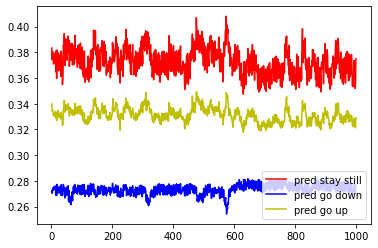

In [53]:
long = 1000#len(test_pred_af)
obs = np.arange(1,long,1)
#====================================================
plt.plot(obs, test_pred[1:long,0], 'r', label = 'pred stay still')
plt.plot(obs, test_pred[1:long,1], 'b', label = 'pred go down')
plt.plot(obs, test_pred[1:long,2], 'y', label = 'pred go up')
#plt.plot(obs, (test_pred[1:long,0]+test_pred[1:long,1]+test_pred[1:long,2]), 'g', label = 'summation')

#plt.plot(obs, train_pred_af[1:long,3], 'r', label = 'pred_y4')

#plt.plot(obs, y_test_mov[1:long,0], 'g', label = 'y1')
#plt.plot(obs, y_test_mov[1:long,1], 'b', label = 'y2')
#plt.plot(obs, y_test_mov[1:long,2], 'tab:cyan', label = 'y3')
#plt.plot(obs, y_train_af[1:long,3], 'tab:cyan', label = 'y4')
plt.legend(loc = 'lower right') 
plt.show()

#print(test_pred_af[1:long,0])

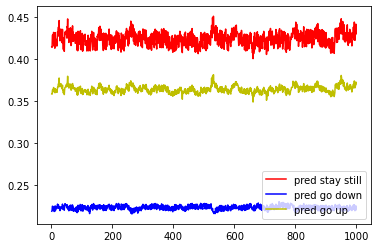

In [54]:
long = 1000#len(test_pred_af)
obs = np.arange(1,long,1)
#====================================================
plt.plot(obs, train_pred[1:long,0], 'r', label = 'pred stay still')
plt.plot(obs, train_pred[1:long,1], 'b', label = 'pred go down')
plt.plot(obs, train_pred[1:long,2], 'y', label = 'pred go up')
#plt.plot(obs, (train_pred[1:long,0]+test_pred[1:long,1]+test_pred[1:long,2]), 'g', label = 'summation')

#plt.plot(obs, train_pred_af[1:long,3], 'r', label = 'pred_y4')

#plt.plot(obs, y_train_mov[1:long,0], 'g', label = 'y1')
#plt.plot(obs, y_train_mov[1:long,1], 'b', label = 'y2')
#plt.plot(obs, y_train_mov[1:long,2], 'tab:cyan', label = 'y3')
#plt.plot(obs, y_train_af[1:long,3], 'tab:cyan', label = 'y4')
plt.legend(loc = 'lower right') 
plt.show()

#print(test_pred_af[1:long,0])

In [ ]:
obs = np.arange(1,100,1)
#====================================================
plt.plot(obs, test_pred_af[1:100,1], 'r', label = 'pred_y2')

plt.plot(obs, y_test_af[1:100,1], 'g', label = 'y2')
plt.legend(loc = 'upper right')
plt.show()

##### 